# Collaborative Filtering - Matrix Factorization
In this Notebook, we will be performing collaborative filtering using matrix factorization. The steps we will follow are detailed in the introduction. We will be using TensorFlow as our ML framework for the development of our music recommender system. Let's begin by building a sparse representation of our ratings matrix.

In [128]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
from matplotlib import pyplot as plt
tf.compat.v1.disable_eager_execution()

In [129]:
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

## Feature Engineering

In the following cells, we will be re-mapping our user ID's to fit into a scale that is defined as being greater than 0, and less than or equal to the number of unique users. Currently, despite there being only 1,892 unique users, profiles exist with ID's such as 1,893, 2,000, and so on. Mapping our user ID's to a suitable scale is good practice and will avoid issues in the future.

The exact same principle will be applied to the artist ID's.

In [130]:
#Let's define our amount of users
rating_matrix = pd.read_csv('../data/user_artists.dat', sep='\t', encoding='latin-1')
num_users = len(rating_matrix.userID.unique())

#Extract userID column
userids = np.asarray(rating_matrix.userID)

#Remap the column
u_mapper, u_ind = np.unique(userids, return_inverse=True)

In [131]:
#Let's define our amount of artists
artists = pd.read_csv('../data/artists.dat', sep='\t', encoding='latin-1')
num_artists = len(artists.id.unique())

#Extract artistID column
artistids = np.asarray(rating_matrix.artistID)

#Remap the column
a_mapper, a_ind = np.unique(artistids, return_inverse=True)

In [132]:
#Assert that u_ind and userID column are of same size
assert(len(u_ind) == len(rating_matrix.userID))

#Assert that a_ind and artistID column are of same size
assert(len(a_ind) == len(rating_matrix.artistID))

In [133]:
# Let's replace old columns with new ind ones
rating_matrix.userID = u_ind
rating_matrix.artistID = a_ind

#Let's ensure the max value is approriate
assert(rating_matrix.userID.unique().max() == 1891)
assert(rating_matrix.artistID.unique().max() == 17631)

In [138]:
rating_matrix.describe()

,userID,artistID,weight
count,92834.000,92834.000,92834.000
mean,944.222,3235.737,0.001
std,546.751,4197.217,0.003
min,0.000,0.000,0.000
25%,470.000,430.000,0.000
50%,944.000,1237.000,0.000
75%,1416.000,4266.000,0.001
max,1891.000,17631.000,0.303


Our 'ratings' value consists of the number of listens a user has for a particular artist. These values can range from 1 all the way up to 352,698. Having inputs that vary this greatly reduces the profficiency of our model. Therefore, we will normalise the values using Keras normalize, with `order=2`. This means the inputs are normalized so that the summation of the normalized inputs squared is equal to 1.

In [134]:
#What is the max amount of listens
print(f'The max value recorded: {rating_matrix.weight.max()}')


#normalize the weight array
rating_matrix.weight = tf.keras.utils.normalize(np.asarray(rating_matrix.weight), order=2)[0]

The max value recorded: 352698


## Sparse Representation of $A$
Let's define a helper function which will build a sparse representation of our ratings matrix $A$. We will use TensorFlow `SparseTensor` to generate our sparse representation.

In [69]:
#Function to build sparse representation of rating matrix
def build_rating_sparse_tensor(ratings_df):
    """
    Args:
    ratings_df: a pd.DataFrame with `userID`, `artistID` and `weight` columns.
    Returns:
    a tf.SparseTensor representing the ratings matrix.
    """
    indices = ratings_df[['userID', 'artistID']].values
    values = ratings_df['weight'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[num_users, num_artists])

In [70]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
        df: a dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
        train: dataframe for training
        test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

## Error Function
Let's define our error function. We will be using **Mean Square Error** (MSE).

In [71]:
def sparse_mean_square_error(sparse_ratings, query_embeddings, item_embeddings):
    """
    Args:
        sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
        query_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
        dimension, such that U_i is the embedding of user i.
        item_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
        dimension, such that V_j is the embedding of movie j.
    Returns:
        A scalar Tensor representing the MSE between the true ratings and the
        model's predictions.
    """
    predictions = tf.gather_nd(
        tf.matmul(query_embeddings, item_embeddings, transpose_b=True),
        sparse_ratings.indices)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## CFModel Helper Class
Below you will find a useful helper class for collaborative filtering extracted from the [Google Recommendation System Colab notebook](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=TOVDyYHgo4th). It is a simple class for training a CF Model using *Stochastic Gradient Descent* (SGD). As is explained in the introduction, we will not be using *Alternating Least Squares* (ALS) as the benefits of the algorithm will not be recognised in our approach.

In [72]:
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

In [73]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
        ratings: a DataFrame of the ratings
        embedding_dim: the dimension of the embedding vectors.
        init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
        model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "user_id": U,
        "movie_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.019096, test_error=0.466000

[{'train_error': 0.019096144, 'test_error': 0.46600005}]

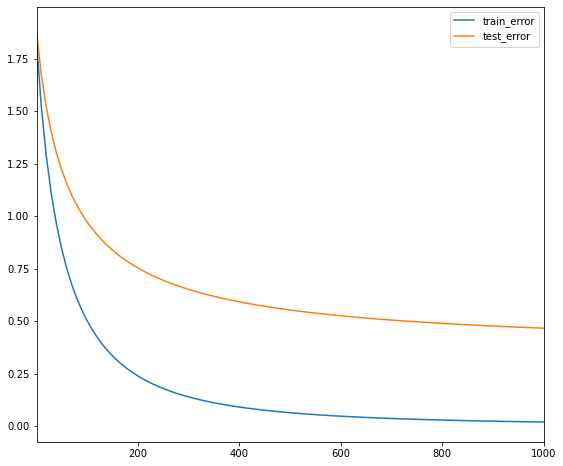

In [137]:
model = build_model(rating_matrix, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)